In [1]:
import os, sys

import tensorflow as tf
import numpy      as np

from matplotlib import pyplot as plt

sys.path.append("/".join(os.getcwd().split("/")[:-1]))

from mathsformer import tf_objects as tfo

In [2]:
def sigmoid(x) :
    return 1 / (1 + np.exp(-x))

def inv_sigmoid(x) :
    return -np.log(1/x - 1)

In [18]:

'''
class GradientFlowEncoder(tfo.EncoderBlock) :
    def __init__(self, **kwargs) :
        super().__init__(**kwargs)
        
    def call(self, x, mask=None) :        
        y1 = super().call(x, mask=mask)
        
        y2 = tf.gradients(y1, x)[0]
        y3 = tf.reduce_sum(y2, axis=-1)
        y4 = tf.gradients(y3, x)[0]
        return x - y4
'''

'''
class GradientFlowEncoder(tfo.EncoderBlock) :
    
    def __init__(self, **kwargs) :
        """
        """
        super().__init__(**kwargs)
        self._flatten = Flatten()
        
    def call(self, x, mask=None) :
        """
        """
        with tf.GradientTape() as tape :
            tape.watch(x)
            y    = super().call(x, mask=mask)
            jac  = tfp.math.diag_jacobian(x, y, fn=super().call)[1][0]
            grad = tf.reduce_sum(jac, axis=-1)
            
        div = tape.gradient(grad, x)
        
        return x - 0.1*div
'''
    

'''
class GradientFlowEncoder(tfo.EncoderBlock) :
    def __init__(self, **kwargs) :
        super().__init__(**kwargs)
        self._flatten = Flatten()
        
    def call(self, x, mask=None) :
                
        with tf.GradientTape(persistent=True) as t2:
            t2.watch(x)
            with tf.GradientTape(persistent=True) as t1:
                t1.watch(x)
                y = super().call(x, mask=mask)
            jac  = t1.batch_jacobian(y, x)
            grad = tf.reduce_sum(tf.linalg.tensor_diag_part(jac), axis=-1)
        div = t2.gradient(grad, x)
        
        return x - 0.1*div
'''
    
from tensorflow.keras.layers import Flatten
import tensorflow_probability as tfp


class GradientFlowEncoder(tfo.EncoderBlock) :
    def __init__(self, *args, **kwargs) :
        super().__init__(*args, **kwargs)
        
    def build(self, x) :
        self._weight = self.add_weight(f"{self.name}_weight", 
                                       shape=(1,), 
                                       initializer=tf.constant_initializer(inv_sigmoid(0.2)), 
                                       trainable=True, 
                                       dtype=self.dtype)
        
    def call(self, x, mask=None) :
                        
        with tf.GradientTape() as tape :
            tape.watch(x)
            y = super().call(x, mask=mask)
            y = tf.reduce_sum(y, axis=-1)
            y = tf.reduce_sum(y, axis=-1)
            y = tf.nn.sigmoid(y)
            y = y[..., tf.newaxis]
            
        div = tape.batch_jacobian(y, x)
        div = div[:,0,:,:]       
        lam = tf.nn.sigmoid(self._weight)
        return x - lam*div
    
    

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None, 1)]         0         
                                                                 
 gradient_flow_encoder_4 (Gr  (None, None, 1)          1147      
 adientFlowEncoder)                                              
                                                                 
Total params: 1,147
Trainable params: 1,147
Non-trainable params: 0
_________________________________________________________________
499

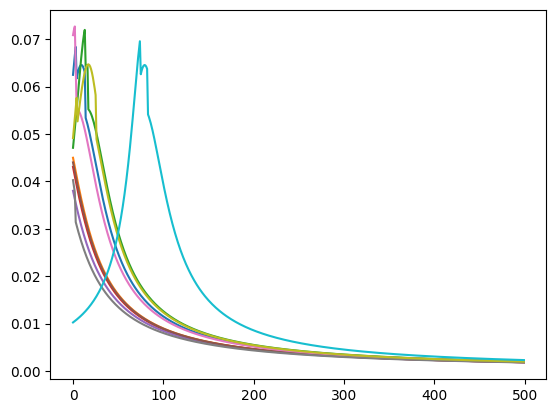

In [19]:
from tensorflow.keras.layers import Dense, Embedding, Input, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam

x_in = Input((None, 1))

s1 = GradientFlowEncoder(ndim_out=1, ndim_hidden_mha=32, ndim_hidden_ff=32, num_heads=8,
                         pre_layer_norm=False, post_layer_norm=False)

block = Model(x_in, s1(x_in))
block.summary()

x = np.random.normal(size=(10, 2, 1))
y = x

Y = [x]
for i in range(500) :
    sys.stdout.write(f"\r{i}")
    y = block(y)
    Y.append(y)
    
Y = np.array(Y)
d = []
for y1, y2 in zip(Y[:-1], Y[1:]) :
    res = y2 - y1
    l2  = np.sqrt(np.sum(np.sum(res*res, axis=-1), axis=-1))
    d.append(l2)

plt.plot(d)
plt.show()


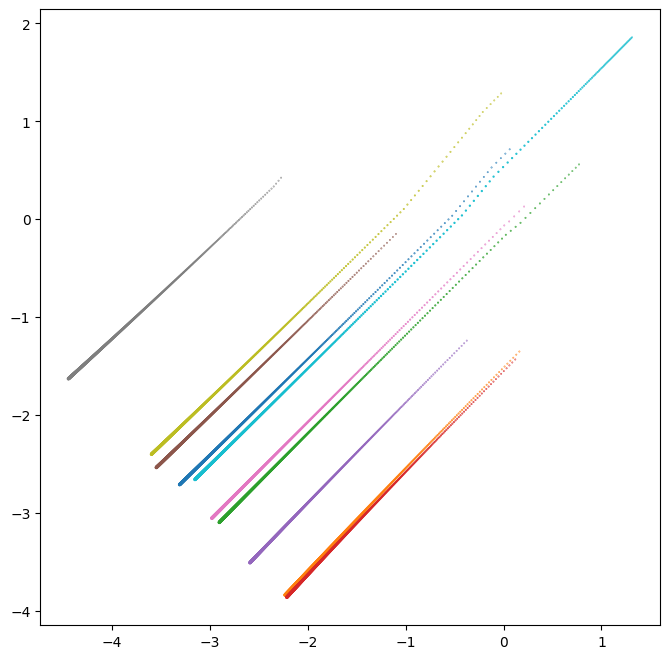

In [24]:

fig = plt.figure(figsize=(8,8))
ax  = fig.add_subplot(1, 1, 1)

for x_idx in range(len(x)) :
    ax.scatter(Y[:,x_idx,0,0], Y[:,x_idx,1,0], marker="o", s=np.linspace(0.1, 2, len(Y)))
    
plt.show()

In [32]:
grid = np.meshgrid(np.linspace(-5, 5, 51), np.linspace(-5, 5, 51))
grid = np.concatenate([grid[0].flatten(), grid[1].flatten()])

vals = block.predict(grid[:,None])

plt.

163/163 [==============================] - 1s 2ms/step


array([[[-5.003002 ]],

       [[-4.8034883]],

       [[-4.604048 ]],

       ...,

       [[ 4.998834 ]],

       [[ 4.998834 ]],

       [[ 4.998834 ]]], dtype=float32)

In [8]:

class Squeeze(Layer) :
    def call(self, x, mask=None) :
        return x[..., 0]

x_in = Input((None, 1))
x    = Squeeze()(x_in)

x = Embedding(input_dim=15, output_dim=64, mask_zero=True)(x)

s1 = GradientFlowEncoder(ndim_out=64, ndim_hidden_mha=512, ndim_hidden_ff=512, num_heads=8,
                         pre_layer_norm=False, post_layer_norm=False)

for i in range(5) :
    x = s1(x)
    
x = Dense(1)(x)

m = Model(x_in, x)
m.compile(loss="mse", optimizer=Adam(learning_rate=1e-3))

m.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, 1)]    0           []                               
                                                                                                  
 squeeze (Squeeze)              (None, None)         0           ['input_2[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, None, 64)     960         ['squeeze[0][0]']                
                                                                                                  
 gradient_flow_encoder_1 (Gradi  (None, None, 64)    664705      ['embedding[0][0]',              
 entFlowEncoder)                                                  'gradient_flow_encoder_1[0

In [9]:
X = tf.constant(np.random.randint(15, size=(100, 40, 1)))
Y = tf.constant(np.random.randint(15, size=(100, 40, 1)))

y = m(X)
print(y.shape)

(100, 40, 1)


In [10]:
y = m.predict(X)
print(y.shape)

4/4 [==============================] - 3s 284ms/step
(100, 40, 1)


In [11]:

m.fit(X, Y, epochs=40, batch_size=16)


Epoch 1/40
7/7 [==============================] - 8s 431ms/step - loss: 68.7559
Epoch 2/40
7/7 [==============================] - 3s 423ms/step - loss: 67.9059
Epoch 3/40
7/7 [==============================] - 3s 442ms/step - loss: 67.2366
Epoch 4/40
7/7 [==============================] - 3s 437ms/step - loss: 66.5112
Epoch 5/40
7/7 [==============================] - 3s 434ms/step - loss: 65.6822
Epoch 6/40
7/7 [==============================] - 3s 441ms/step - loss: 64.8063
Epoch 7/40
7/7 [==============================] - 3s 435ms/step - loss: 63.8334
Epoch 8/40
7/7 [==============================] - 3s 441ms/step - loss: 62.7582
Epoch 9/40
7/7 [==============================] - 3s 435ms/step - loss: 61.5987
Epoch 10/40
7/7 [==============================] - 3s 430ms/step - loss: 60.3470
Epoch 11/40
7/7 [==============================] - 3s 438ms/step - loss: 58.9790
Epoch 12/40
7/7 [==============================] - 3s 450ms/step - loss: 57.5131
Epoch 13/40
7/7 [====================

KeyboardInterrupt: 